# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Evaluation

In this jupyter notebook, we evaluate our model for diabetes patients early readmission prediction.

TODO PRECO RF A PRECO UNDERSAMPLED

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Needed for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV

from sklearn.manifold import TSNE

from sklearn.metrics import roc_auc_score, auc

from src.preprocessing.helpers import describe_dataset
from src.evaluation import *

In [4]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Load train and test data

In [5]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [6]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 81409
Number of test data: 20353
Number of features: 53
Classes:
	0 :
	    train: 72315 samples, 89.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 11.0%
	    test: 2263 samples, 11.0%



#### Data balancing

Random undersampling

In [7]:
X_train, y_train = undersample(X_train, y_train)

In [8]:
len(X_train), len(y_train)

(18188, 18188)

### Data visualization

kedze slabe vysledky, T-SNE. Je to vsak valid?

In [9]:
%%time

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_train)

CPU times: user 10min 34s, sys: 851 ms, total: 10min 35s
Wall time: 6min 8s


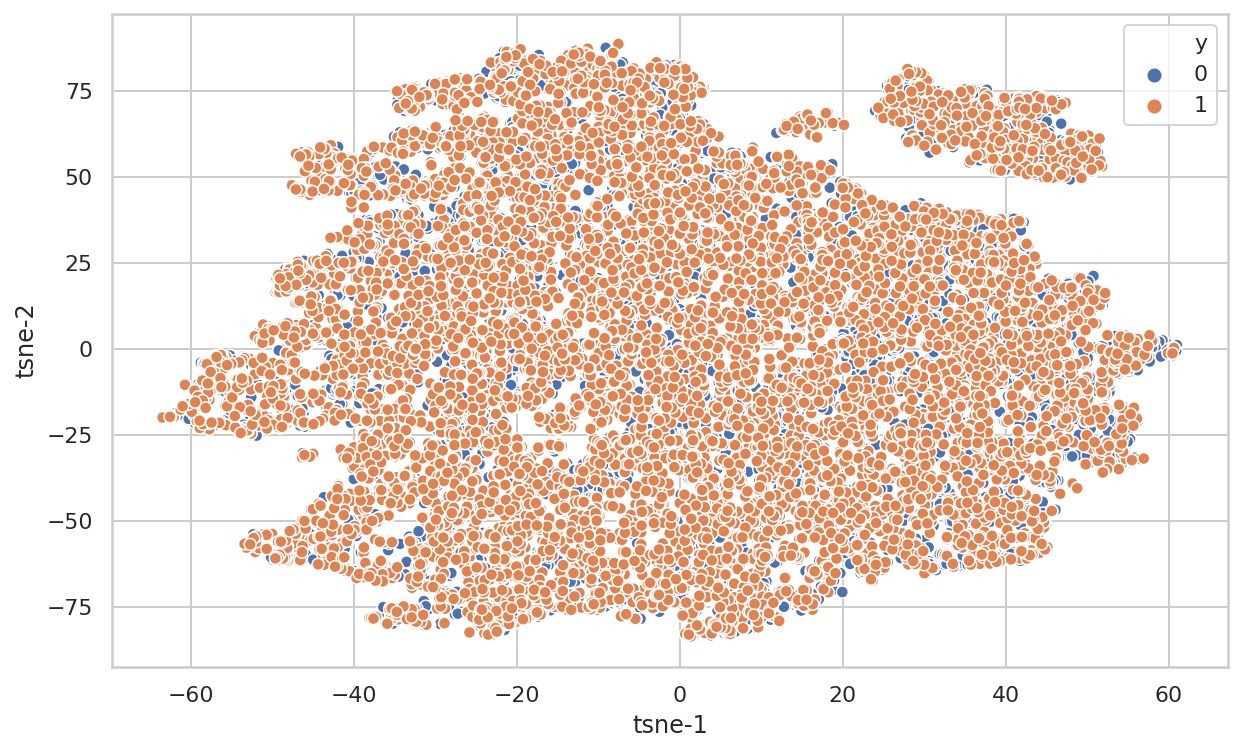

In [10]:
df_tsne = pd.DataFrame({
    'tsne-1': tsne_result[:,0],
    'tsne-2': tsne_result[:,1],
    'y': list(y_train.readmitted)
})

sns.scatterplot('tsne-1', 'tsne-2', hue='y', data=df_tsne, legend='full');

In [11]:
%%time

tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(X_train)

CPU times: user 32min 34s, sys: 2.64 s, total: 32min 36s
Wall time: 14min 4s


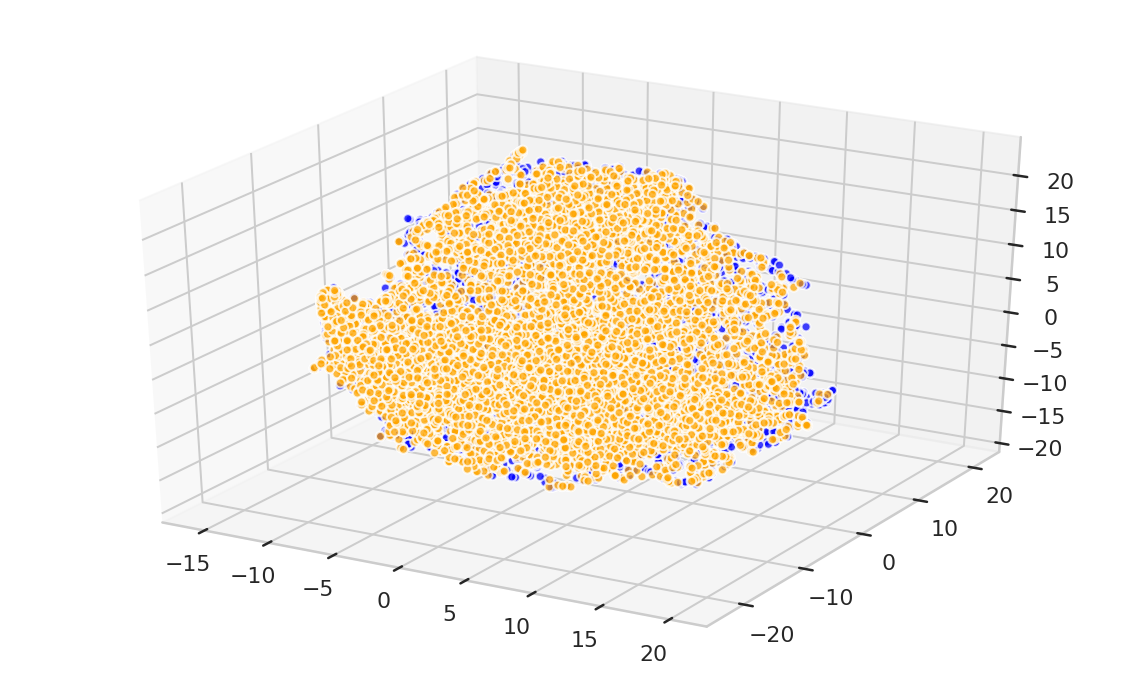

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    tsne_result[:,0],
    tsne_result[:,1],
    tsne_result[:,2],
    c=['orange' if x == 1 else 'blue' for x in list(y_train.readmitted)],
    alpha=0.75,
    edgecolors='w'
)
plt.show()

### Baseline model

In [13]:
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.93      0.59      0.72     18090
           1       0.16      0.63      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.54      0.61      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.651


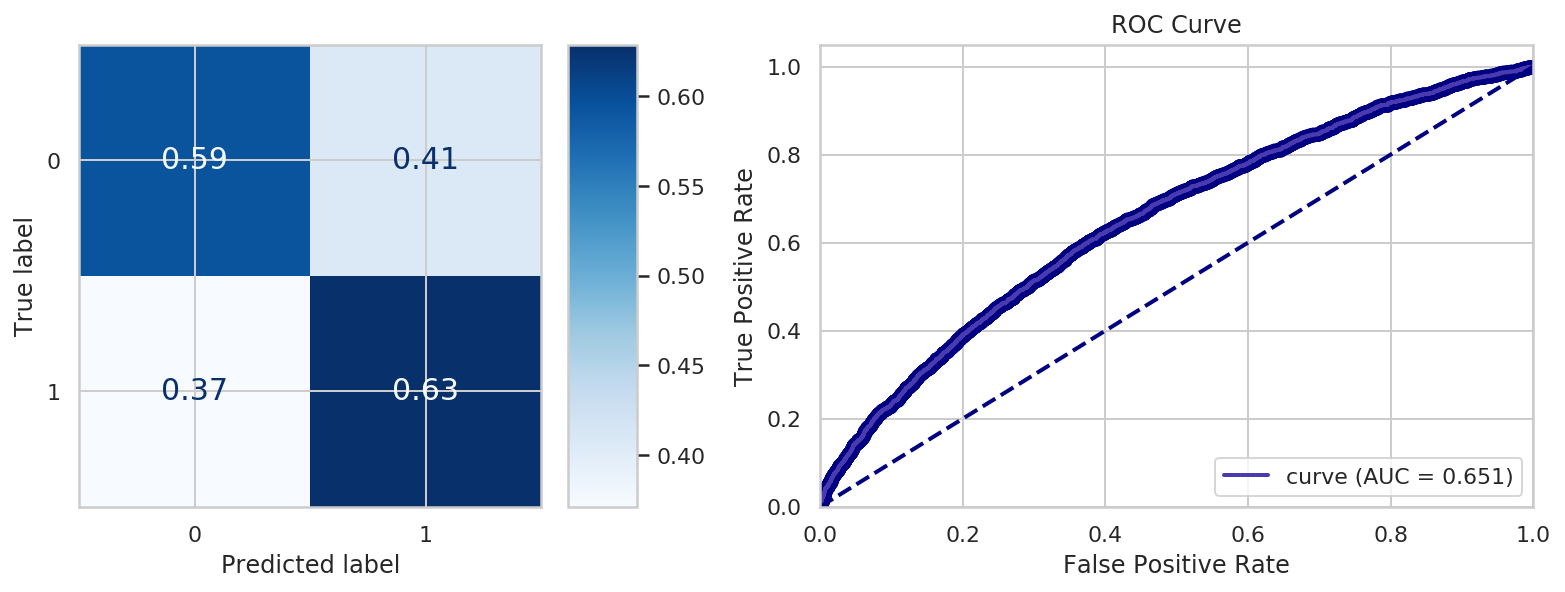

In [14]:
evaluate_model(clf, X_test, y_test)

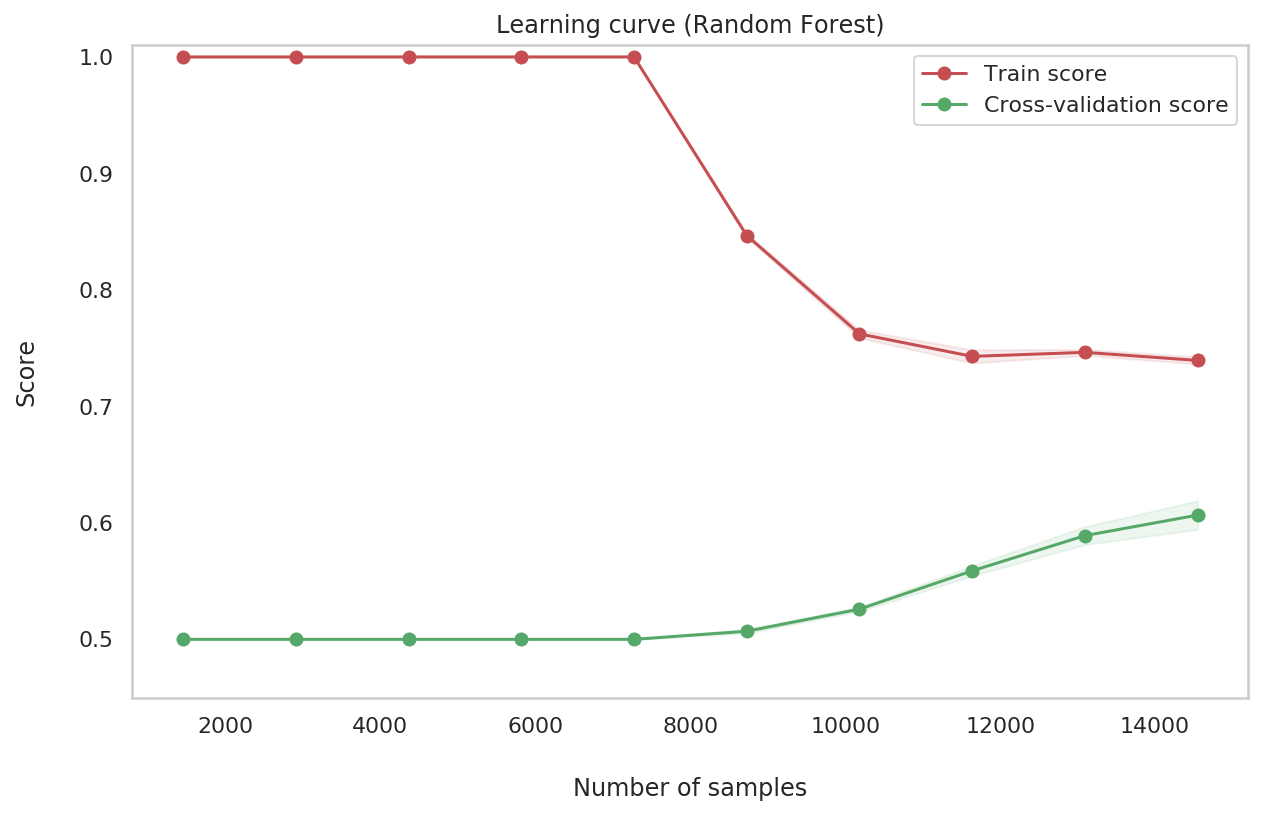

In [15]:
plot_learning_curve(clf, 'Learning curve (Random Forest)', X_train, y_train, cv=5);

### Feature selection

SKusime:
- RFECV
- len odoberat a sledovat ako crty

- porovnat prve s druhym, ake crty vybralo - best estimator z jedneho top 5 crt a z druheho top 5 crt

- stratified CV kvoli highly unbalanced, 5 folds
    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

#### RFECV

In [16]:
clf = RandomForestClassifier(max_depth=10, random_state=42)

In [17]:
%%time

rfecv = RFECV(clf, step=1, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train, y_train)

CPU times: user 12.1 s, sys: 47.2 ms, total: 12.2 s
Wall time: 3min 25s


RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=10, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=0)

Optimal number of features: 49


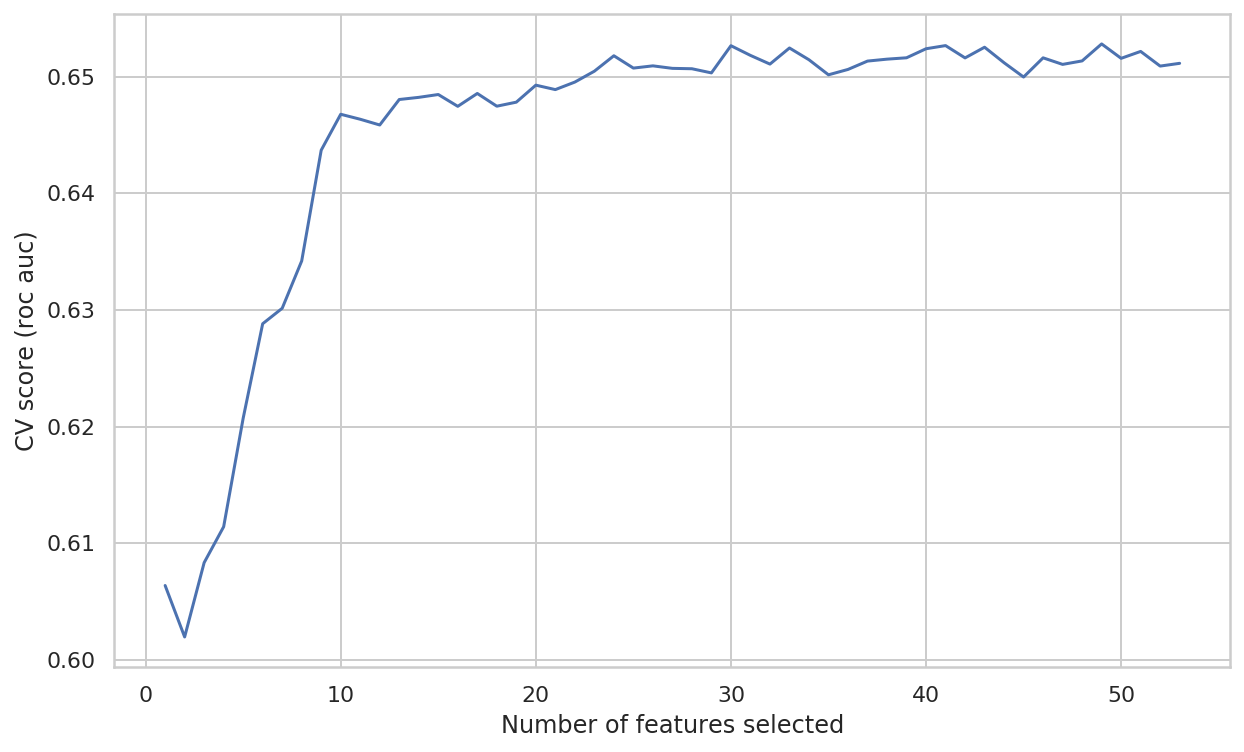

In [18]:
selected_columns = [col for col, selected in zip(X_train.columns, rfecv.support_) if selected]

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('CV score (roc auc)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.59      0.72     18090
           1       0.16      0.62      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.54      0.61      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.651


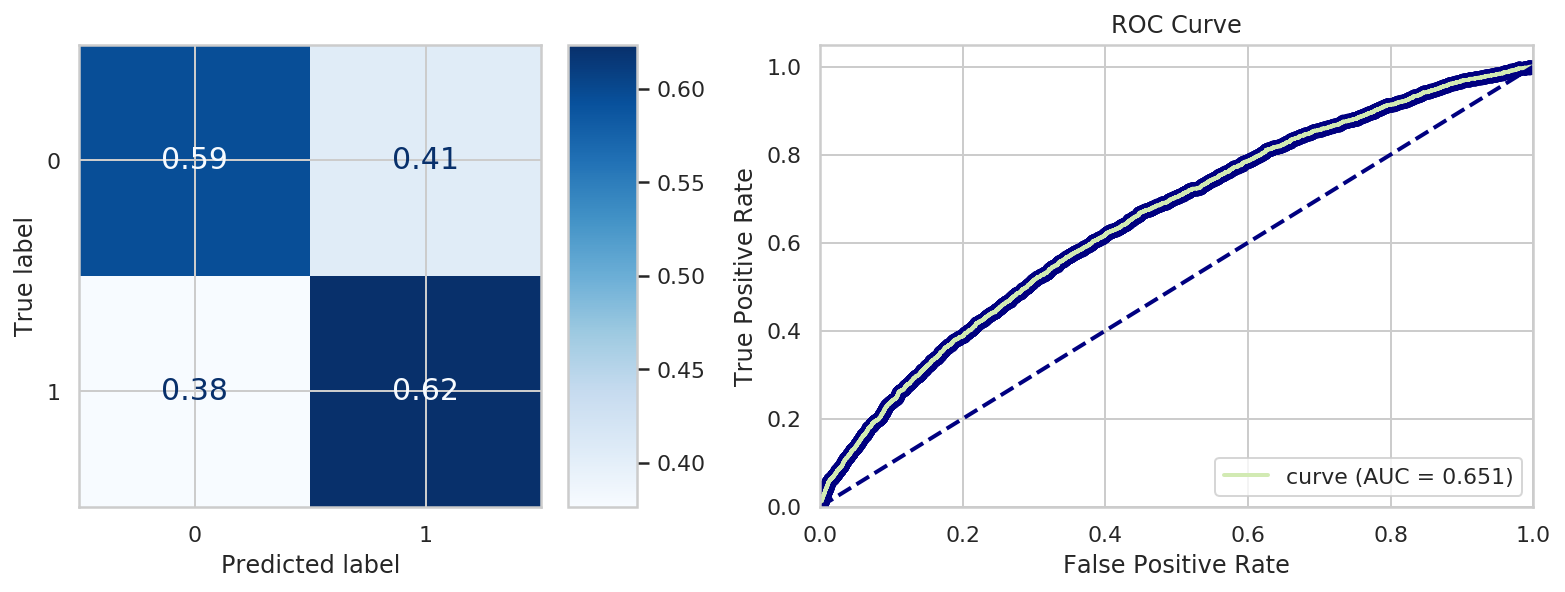

In [19]:
evaluate_model(rfecv.estimator_, X_test[selected_columns], y_test)

In [20]:
set(X_train.columns) - set(selected_columns)

{'diabetesMed_No',
 'diag_3_category_genitourinary',
 'glyburide_other',
 'race_other'}

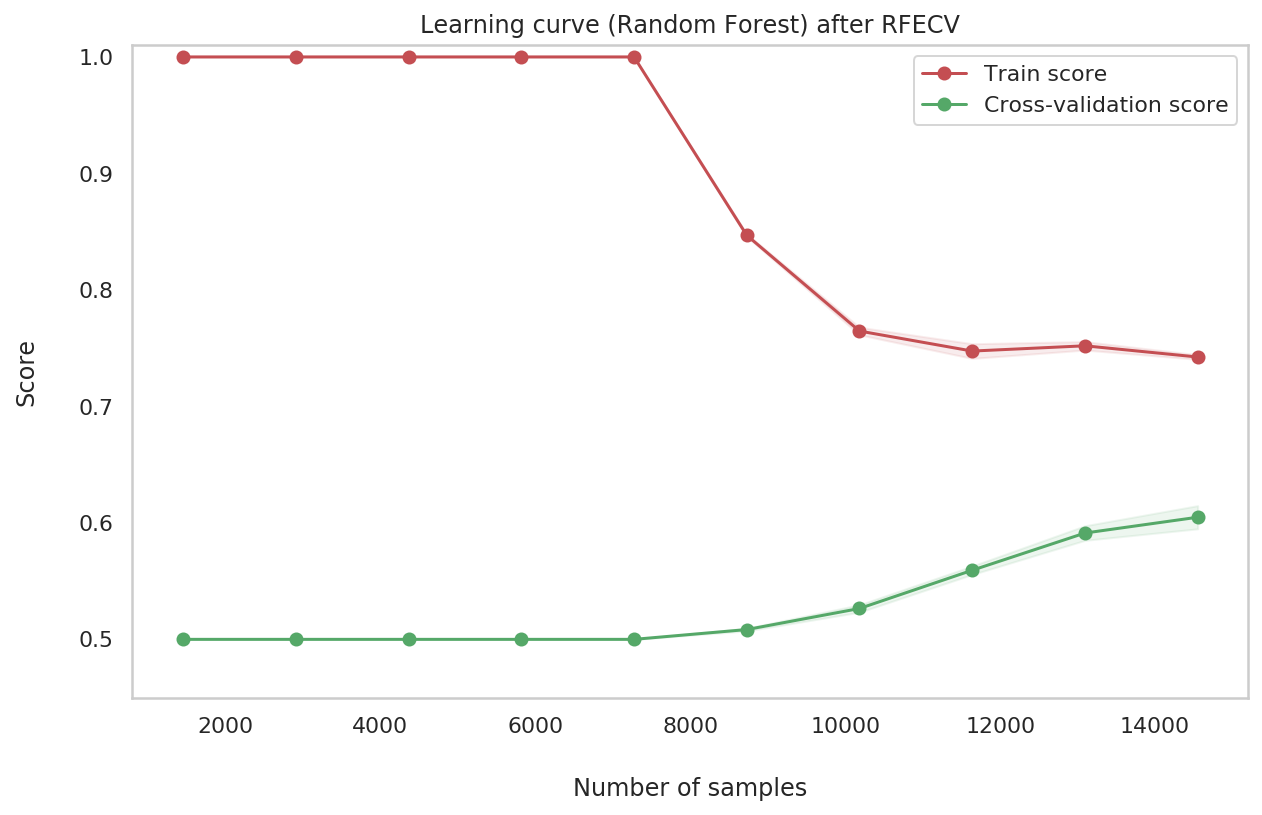

In [21]:
plot_learning_curve(
    rfecv.estimator_,
    'Learning curve (Random Forest) after RFECV',
    X_train[selected_columns],
    y_train,
    cv=5
);

### Hyperparameter tuning

random search

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 60, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Function to measure the quality of a split
criterion = ['gini', 'entropy']

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 12]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [5, 10, 16, 21, 27, 32, 38, 43, 49, 54, 60, None],
 'min_samples_leaf': [1, 2, 4, 8, 12],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [23]:
%%time

rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(), param_distributions=random_grid, scoring="roc_auc",
    n_iter = 10, cv=5, random_state=42, n_jobs=-1
)
rs.fit(X_train[selected_columns], y_train)

CPU times: user 6.16 s, sys: 47 ms, total: 6.2 s
Wall time: 3min 28s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

#### Evaluation

In [24]:
rs.best_score_

0.6534350203387713

In [25]:
rs.best_params_

{'n_estimators': 230,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 49,
 'criterion': 'entropy',
 'bootstrap': True}

Evaluate best model on test data

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     18090
           1       0.16      0.63      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.55      0.61      0.49     20353
weighted avg       0.84      0.60      0.68     20353

ROC AUC score: 0.651


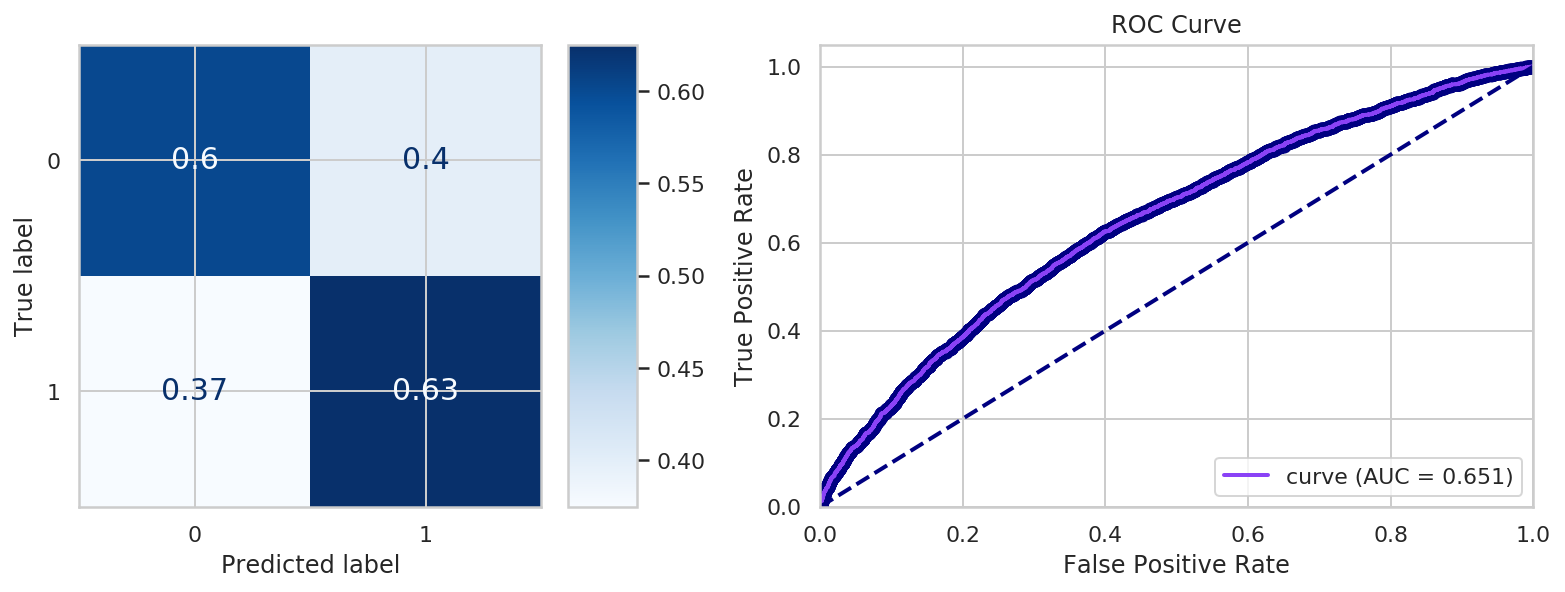

In [26]:
evaluate_model(rs.best_estimator_, X_test[selected_columns], y_test)

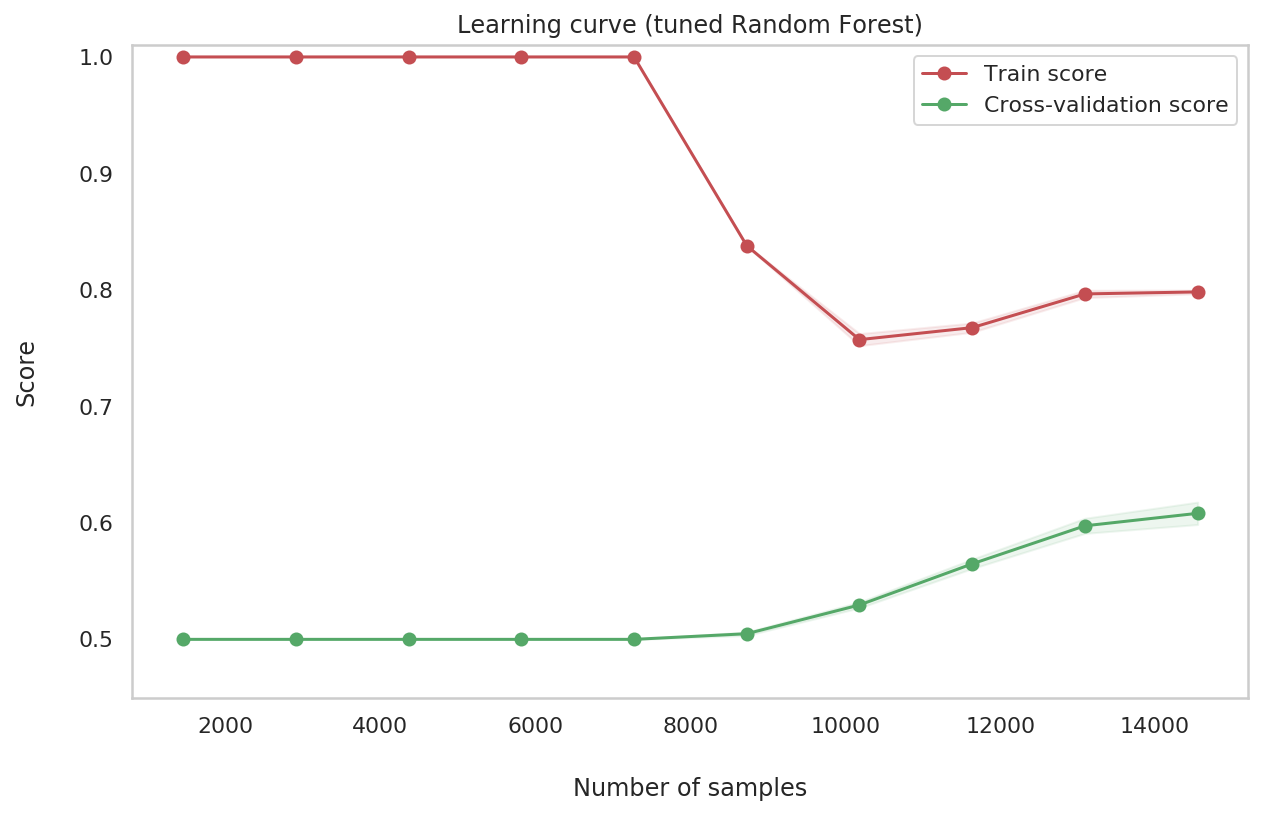

In [27]:
plot_learning_curve(
    rs.best_estimator_,
    'Learning curve (tuned Random Forest)',
    X_train[selected_columns],
    y_train,
    cv=5
);

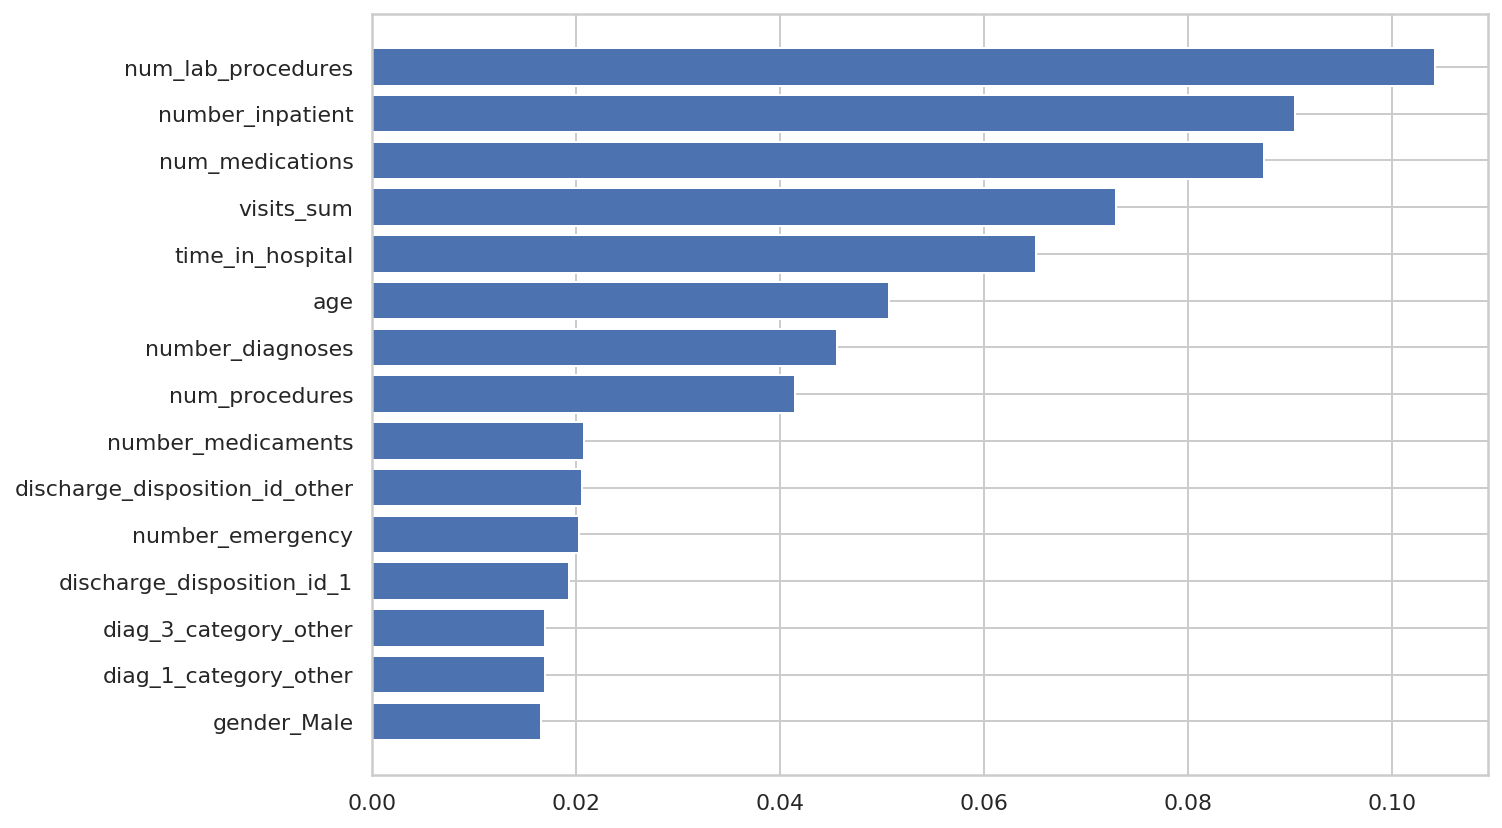

In [28]:
_ = plot_feature_importance(rs.best_estimator_.feature_importances_, X_train[selected_columns].columns, 15)

### Conclusion